<a href="https://colab.research.google.com/github/vidyashankarappa/AdvancedMachineLearning/blob/main/SNP500index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    {"figure.figsize": (6, 4)},
    style='ticks',
    color_codes=True,
    font_scale=0.8
)

import numpy as np
import pandas as pd

import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, PredictionErrorDisplay
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.datasets import make_regression

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import (
    OneHotEncoder,
    TargetEncoder,
    MinMaxScaler,
    StandardScaler,
    PolynomialFeatures
)
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

import shap
shap.initjs()

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/sp-500-stocks")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sp-500-stocks' dataset.
Path to dataset files: /kaggle/input/sp-500-stocks


In [3]:
import os
import pandas as pd
import kagglehub


print("Files in the dataset folder:", os.listdir(path))

csv_file = os.path.join(path, 'sp500_stocks.csv')


df = pd.read_csv(csv_file)

# Display the first few rows to inspect the dataset
print(df.head())

# Check the columns (features)
print("\nFeatures (columns):")
print(df.columns)

Files in the dataset folder: ['sp500_stocks.csv', 'sp500_companies.csv', 'sp500_index.csv']
         Date Symbol  Adj Close  Close  High  Low  Open  Volume
0  2010-01-04    MMM        NaN    NaN   NaN  NaN   NaN     NaN
1  2010-01-05    MMM        NaN    NaN   NaN  NaN   NaN     NaN
2  2010-01-06    MMM        NaN    NaN   NaN  NaN   NaN     NaN
3  2010-01-07    MMM        NaN    NaN   NaN  NaN   NaN     NaN
4  2010-01-08    MMM        NaN    NaN   NaN  NaN   NaN     NaN

Features (columns):
Index(['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open',
       'Volume'],
      dtype='object')


In [4]:
stocks_path = os.path.join(path, 'sp500_stocks.csv')
df_stocks = pd.read_csv(stocks_path)

print("sp500_stocks.csv - First 5 Rows:")
print(df_stocks.head())
print("\nColumns:", df_stocks.columns)


sp500_stocks.csv - First 5 Rows:
         Date Symbol  Adj Close  Close  High  Low  Open  Volume
0  2010-01-04    MMM        NaN    NaN   NaN  NaN   NaN     NaN
1  2010-01-05    MMM        NaN    NaN   NaN  NaN   NaN     NaN
2  2010-01-06    MMM        NaN    NaN   NaN  NaN   NaN     NaN
3  2010-01-07    MMM        NaN    NaN   NaN  NaN   NaN     NaN
4  2010-01-08    MMM        NaN    NaN   NaN  NaN   NaN     NaN

Columns: Index(['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open',
       'Volume'],
      dtype='object')


In [5]:
companies_path = os.path.join(path, 'sp500_companies.csv')
df_companies = pd.read_csv(companies_path)

print("sp500_companies.csv - First 5 Rows:")
print(df_companies.head())
print("\nColumns:", df_companies.columns)


sp500_companies.csv - First 5 Rows:
  Exchange Symbol              Shortname               Longname  \
0      NMS   AAPL             Apple Inc.             Apple Inc.   
1      NMS   NVDA     NVIDIA Corporation     NVIDIA Corporation   
2      NMS   MSFT  Microsoft Corporation  Microsoft Corporation   
3      NMS   AMZN       Amazon.com, Inc.       Amazon.com, Inc.   
4      NMS  GOOGL          Alphabet Inc.          Alphabet Inc.   

                   Sector                        Industry  Currentprice  \
0              Technology            Consumer Electronics        254.49   
1              Technology                  Semiconductors        134.70   
2              Technology       Software - Infrastructure        436.60   
3       Consumer Cyclical                 Internet Retail        224.92   
4  Communication Services  Internet Content & Information        191.41   

       Marketcap        Ebitda  Revenuegrowth           City State  \
0  3846819807232  1.346610e+11          

In [6]:
index_path = os.path.join(path, 'sp500_index.csv')
df_index = pd.read_csv(index_path)

print("sp500_index.csv - First 5 Rows:")
print(df_index.head())
print("\nColumns:", df_index.columns)


sp500_index.csv - First 5 Rows:
         Date   S&P500
0  2014-12-22  2078.54
1  2014-12-23  2082.17
2  2014-12-24  2081.88
3  2014-12-26  2088.77
4  2014-12-29  2090.57

Columns: Index(['Date', 'S&P500'], dtype='object')


In [7]:
df_index.tail(5)

,Date,S&P500
2512,2024-12-16,6074.08
2513,2024-12-17,6050.61
2514,2024-12-18,5872.16
2515,2024-12-19,5867.08
2516,2024-12-20,5930.85


In [8]:
# Parse Date and sort
df_index = df_index.reset_index()
df_index['Date'] = pd.to_datetime(df_index['Date'])
df_index = df_index.sort_values('Date')

In [9]:
df = df_index.copy()

In [10]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [11]:
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Quarter"] = df["Date"].dt.quarter

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   index    2517 non-null   int64         
 1   Date     2517 non-null   datetime64[ns]
 2   S&P500   2517 non-null   float64       
 3   Year     2517 non-null   int32         
 4   Month    2517 non-null   int32         
 5   Quarter  2517 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(3), int64(1)
memory usage: 88.6 KB


In [13]:
df.head(3)

,index,Date,S&P500,Year,Month,Quarter
0,0,2014-12-22,2078.54,2014,12,4
1,1,2014-12-23,2082.17,2014,12,4
2,2,2014-12-24,2081.88,2014,12,4


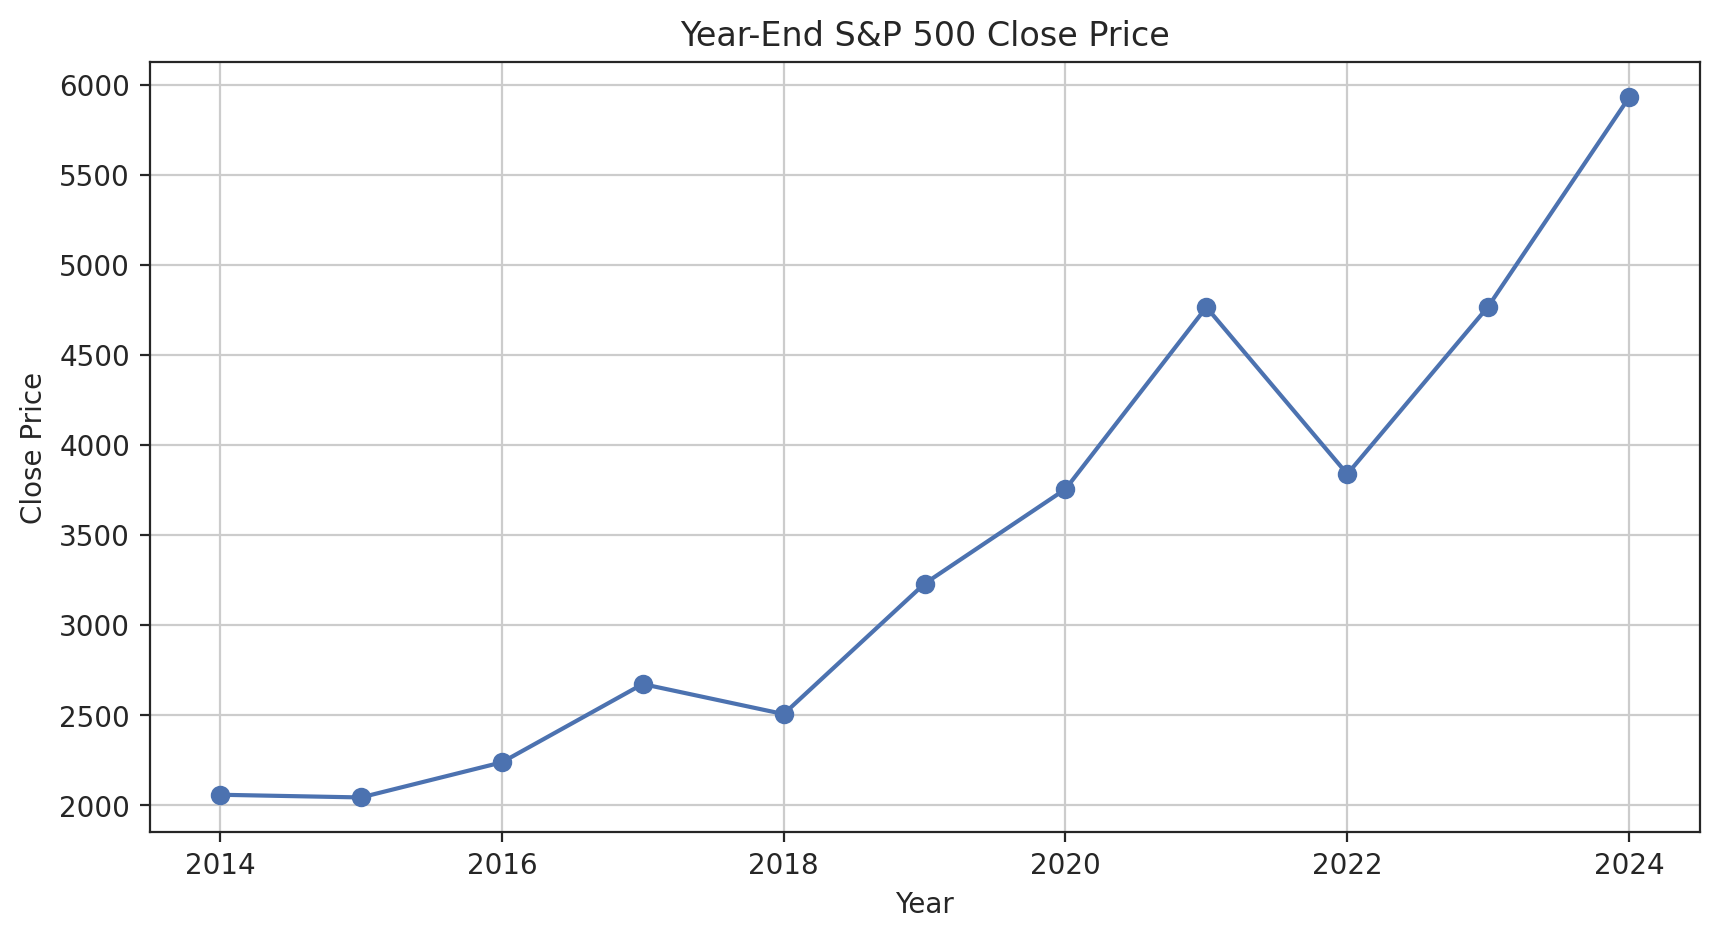

In [14]:
# Resample to get the last available Close of each year
df_year_end = df_index.set_index('Date')['S&P500'].resample('Y').last()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_year_end.index.year, df_year_end.values, marker='o', linestyle='-')
plt.title("Year-End S&P 500 Close Price")
plt.xlabel("Year")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

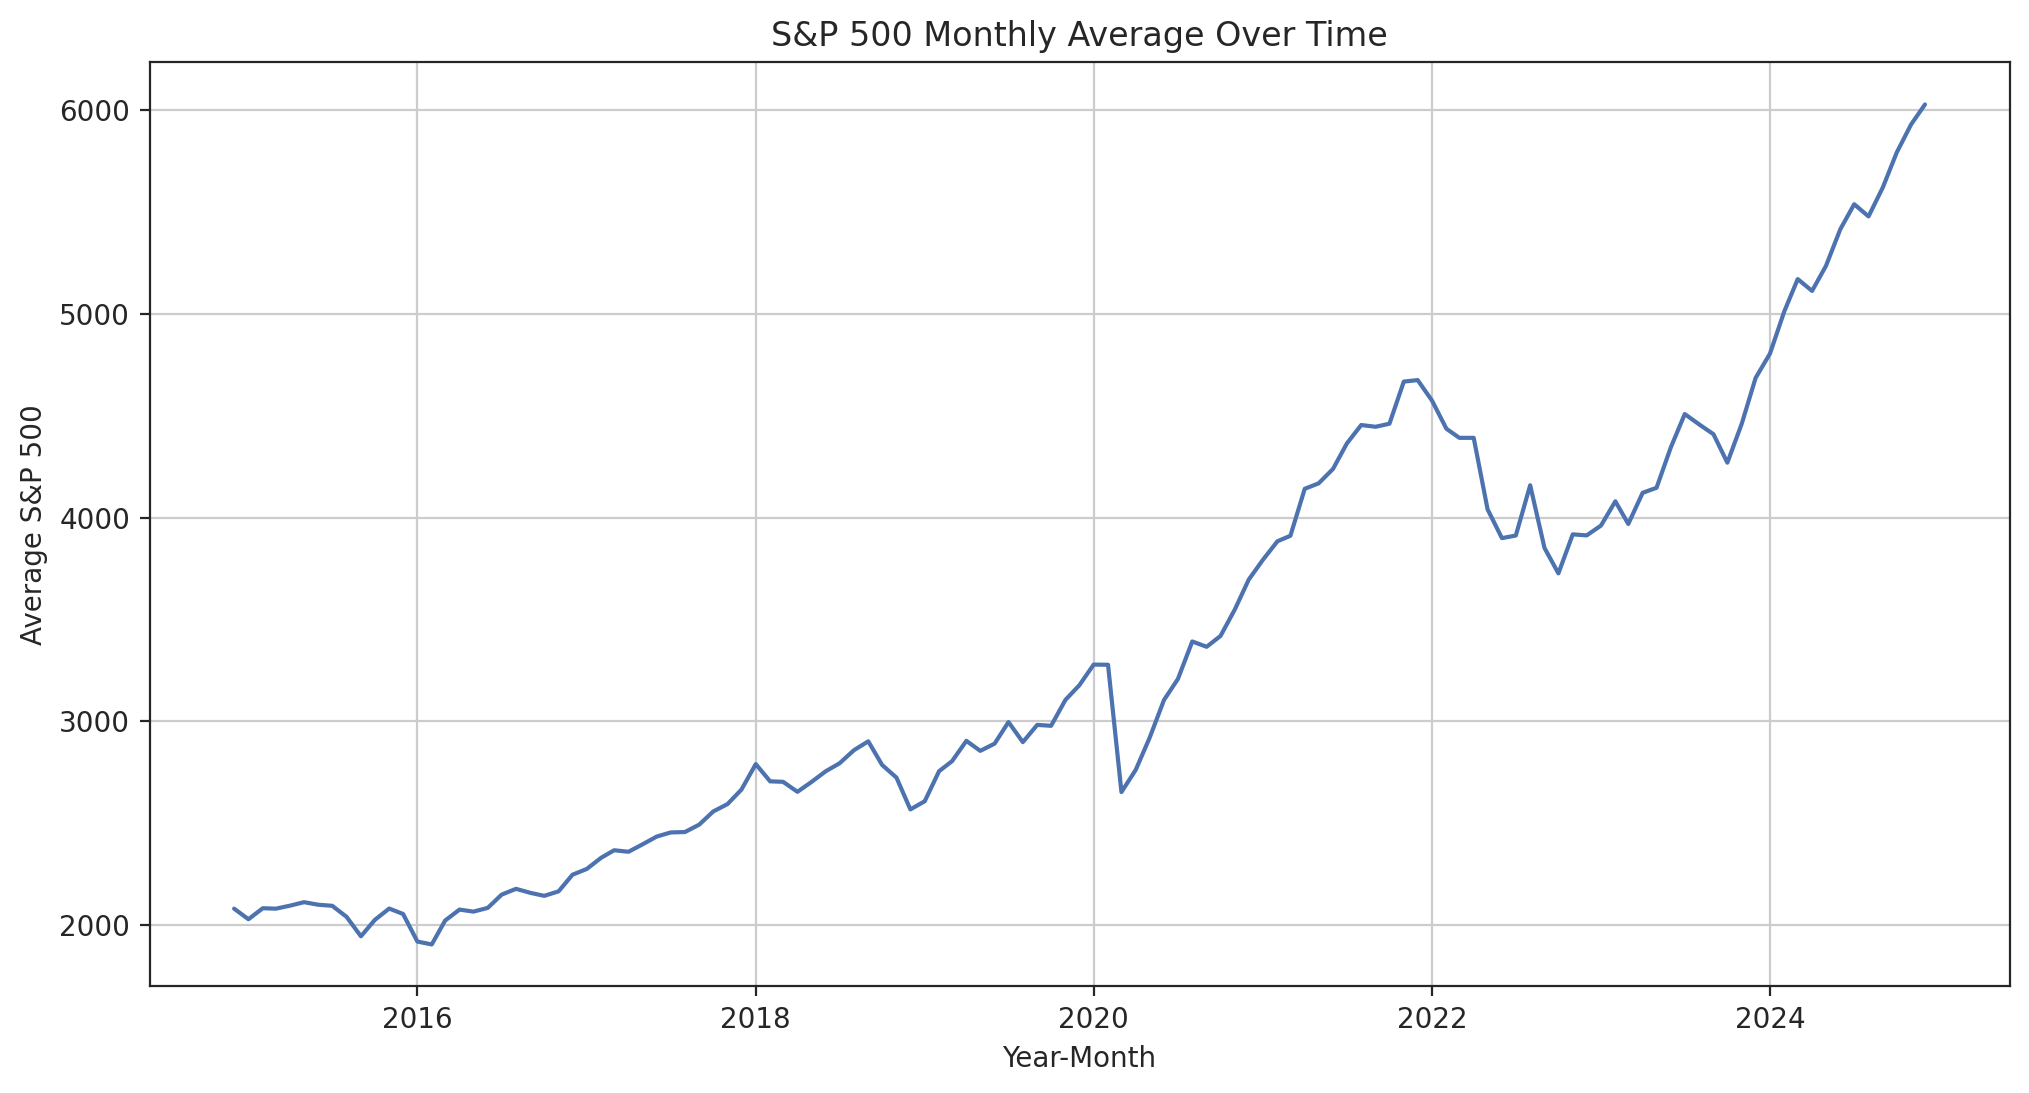

In [15]:
import matplotlib.pyplot as plt

# Create Year-Month as datetime, e.g. '2014-12-01'
df['YearMonth'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01')

# Now group by YearMonth (which is a datetime), take average or sum
monthly_data = df.groupby('YearMonth')['S&P500'].mean()

# Plot the monthly time series
plt.figure(figsize=(12,6))
plt.plot(monthly_data.index, monthly_data.values)
plt.title("S&P 500 Monthly Average Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Average S&P 500")
plt.grid(True)
plt.show()


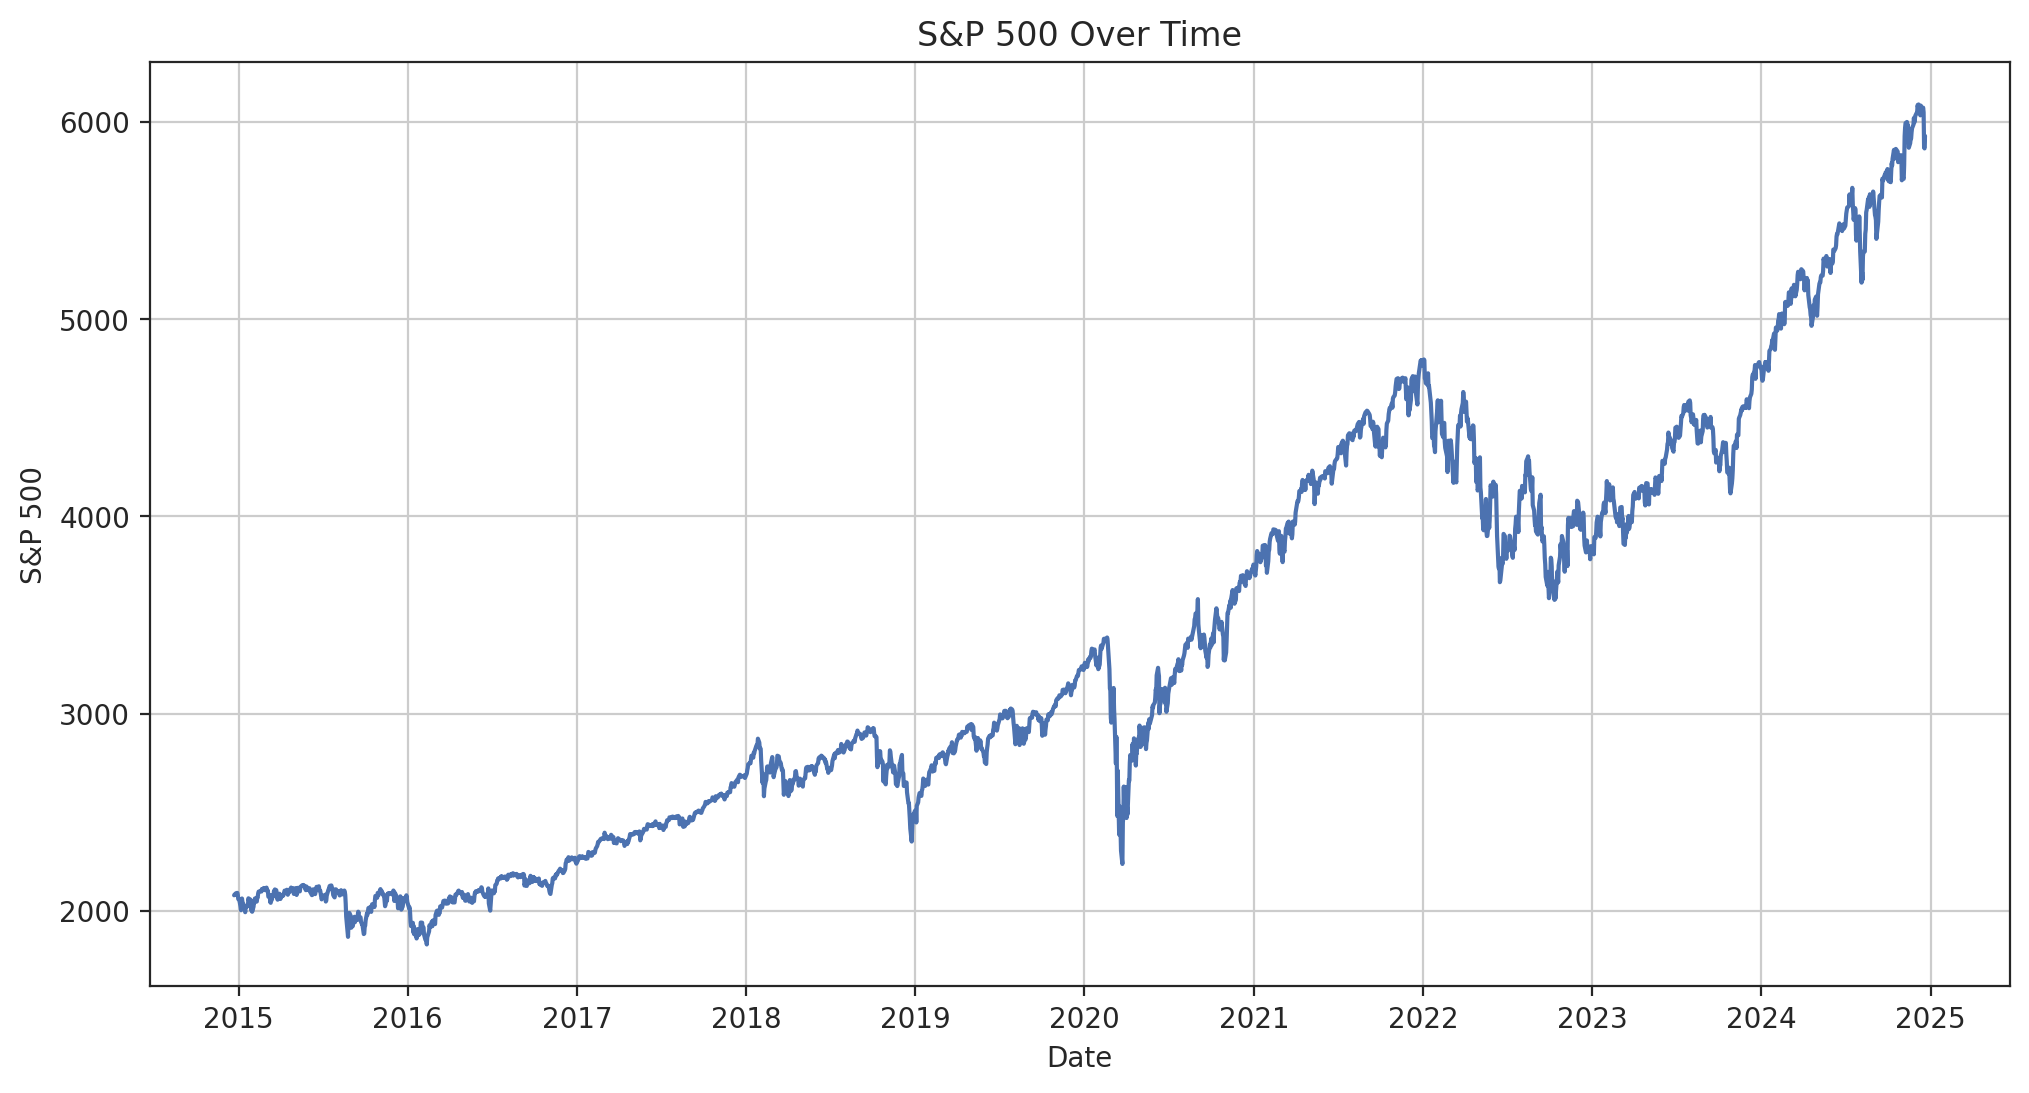

In [16]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['S&P500'])
plt.title("S&P 500 Over Time")
plt.xlabel("Date")
plt.ylabel("S&P 500")
plt.grid(True)
plt.show()


In [17]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['S&P500'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: 0.5450168166956773
p-value: 0.9861789927778164


In [18]:
df_diff = df['S&P500'].diff().dropna()
result_diff = adfuller(df_diff)
print('Differenced ADF Statistic:', result_diff[0])
print('Differenced p-value:', result_diff[1])


Differenced ADF Statistic: -15.941009243000652
Differenced p-value: 7.540700714658545e-29


In [ ]:
#%pip install pmdarima

In [19]:
import warnings
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Prepare the data
series = df['S&P500'].dropna()

# Define the p, d, q parameters to try
p = range(0, 4)
d = [1]  # since differencing once made data stationary
q = range(0, 4)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

warnings.filterwarnings("ignore")  # Ignore warnings from ARIMA fits

best_aic = np.inf
best_order = None
best_model = None

for order in pdq:
    try:
        model = ARIMA(series, order=order)
        model_fit = model.fit()
        print(f'ARIMA{order} - AIC:{model_fit.aic}')
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order
            best_model = model_fit
    except:
        continue

print(f'\nBest ARIMA order: {best_order} with AIC: {best_aic}')


ARIMA(0, 1, 0) - AIC:25352.336948773685
ARIMA(0, 1, 1) - AIC:25339.81685569915
ARIMA(0, 1, 2) - AIC:25337.36060675663
ARIMA(0, 1, 3) - AIC:25338.223942692206
ARIMA(1, 1, 0) - AIC:25338.673066724114
ARIMA(1, 1, 1) - AIC:25337.94885785502
ARIMA(1, 1, 2) - AIC:25338.89235790532
ARIMA(1, 1, 3) - AIC:25339.048031681286
ARIMA(2, 1, 0) - AIC:25337.145646393066
ARIMA(2, 1, 1) - AIC:25339.07536225184
ARIMA(2, 1, 2) - AIC:25272.520943582353
ARIMA(2, 1, 3) - AIC:25332.905184862866
ARIMA(3, 1, 0) - AIC:25338.93538771136
ARIMA(3, 1, 1) - AIC:25339.599921891182
ARIMA(3, 1, 2) - AIC:25273.760709450195
ARIMA(3, 1, 3) - AIC:25276.115889607365

Best ARIMA order: (2, 1, 2) with AIC: 25272.520943582353


                               SARIMAX Results                                
Dep. Variable:                 S&P500   No. Observations:                 2517
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -12631.260
Date:                Thu, 25 Sep 2025   AIC                          25272.521
Time:                        18:05:10   BIC                          25301.673
Sample:                             0   HQIC                         25283.101
                               - 2517                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7643      0.021    -84.053      0.000      -1.805      -1.723
ar.L2         -0.8815      0.020    -44.298      0.000      -0.920      -0.842
ma.L1          1.7022      0.026     66.038      0.0

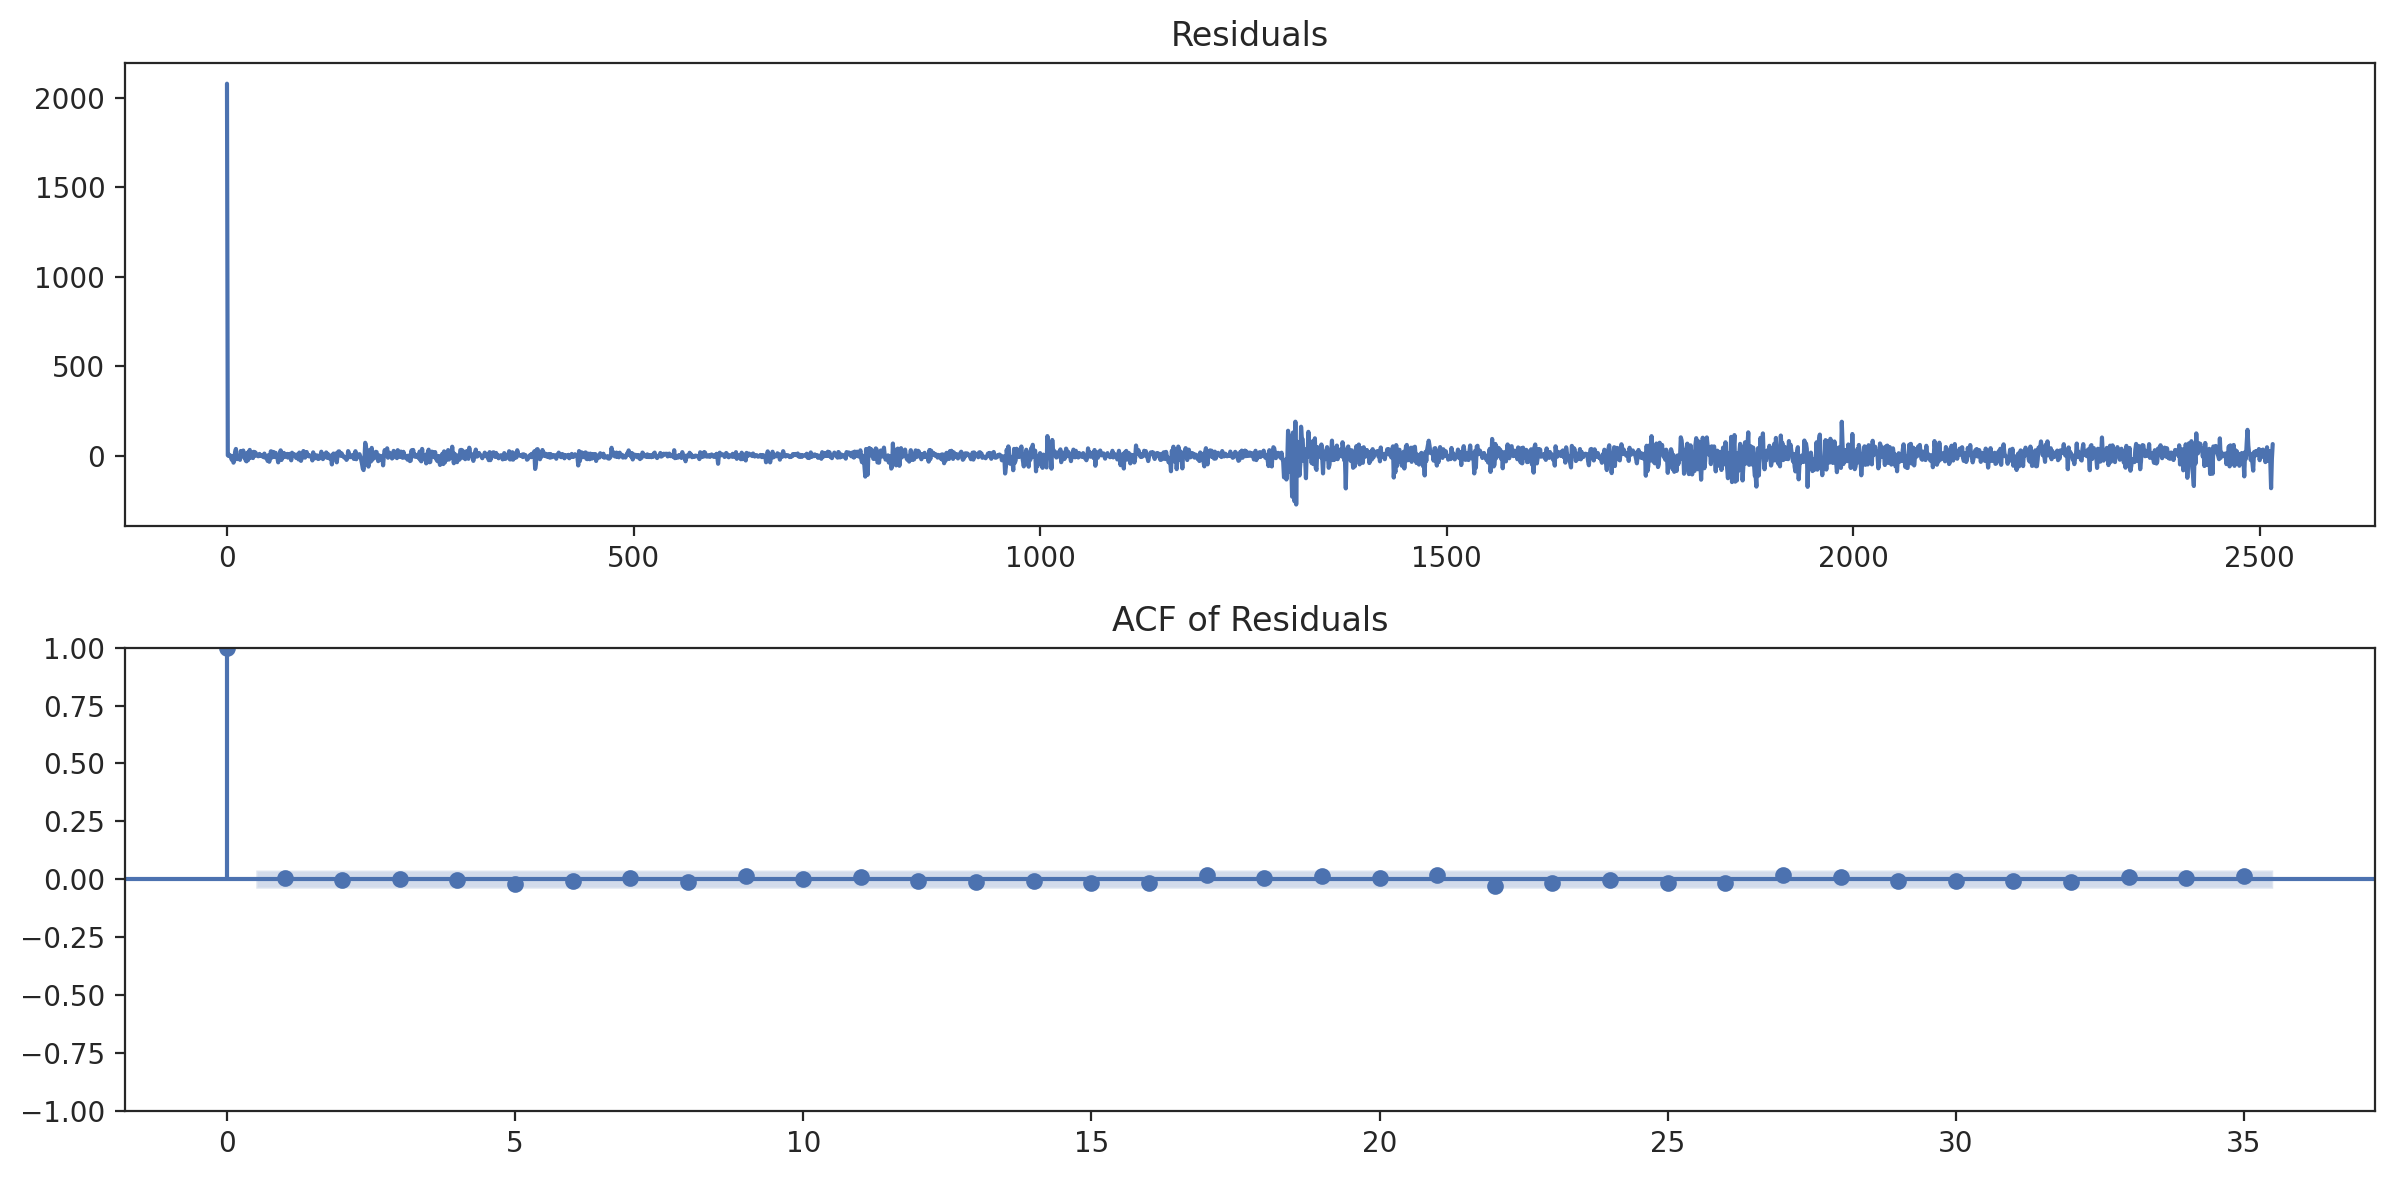

In [20]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Fit the best ARIMA model
model = ARIMA(df['S&P500'].dropna(), order=(2, 1, 2))
model_fit = model.fit()

print(model_fit.summary())

# Plot the residuals to check for randomness
residuals = model_fit.resid

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals')

plt.subplot(212)
plot_acf(residuals, ax=plt.gca())
plt.title('ACF of Residuals')

plt.tight_layout()
plt.show()


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming your df looks like this:
# df.index = DatetimeIndex (e.g. daily business days)
# df['S&P500'] = historical closing prices

# Step 1: Fit the ARIMA model
# (Use the best order you found, e.g., (2,1,2))
order = (2, 1, 2)
model = ARIMA(df['S&P500'], order=order)
model_fit = model.fit()

# Step 2: Forecast for next 252 business days (~1 year)
forecast_steps = 252
forecast = model_fit.get_forecast(steps=forecast_steps)

# Step 3: Create forecast index starting from the day after last date in df
last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='B')

# Step 4: Extract forecasted mean and confidence intervals
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
conf_int = forecast.conf_int()

# Step 5: Plot observed data and forecast
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['S&P500'], label='Observed')
plt.plot(forecast_index, forecast_series, color='red', label='Forecast')

# Plot confidence intervals
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title('S&P 500 Forecast for Next Year')
plt.xlabel('Date')
plt.ylabel('S&P 500')
plt.legend()
plt.show()


TypeError: unsupported operand type(s) for +: 'int' and 'Timedelta'

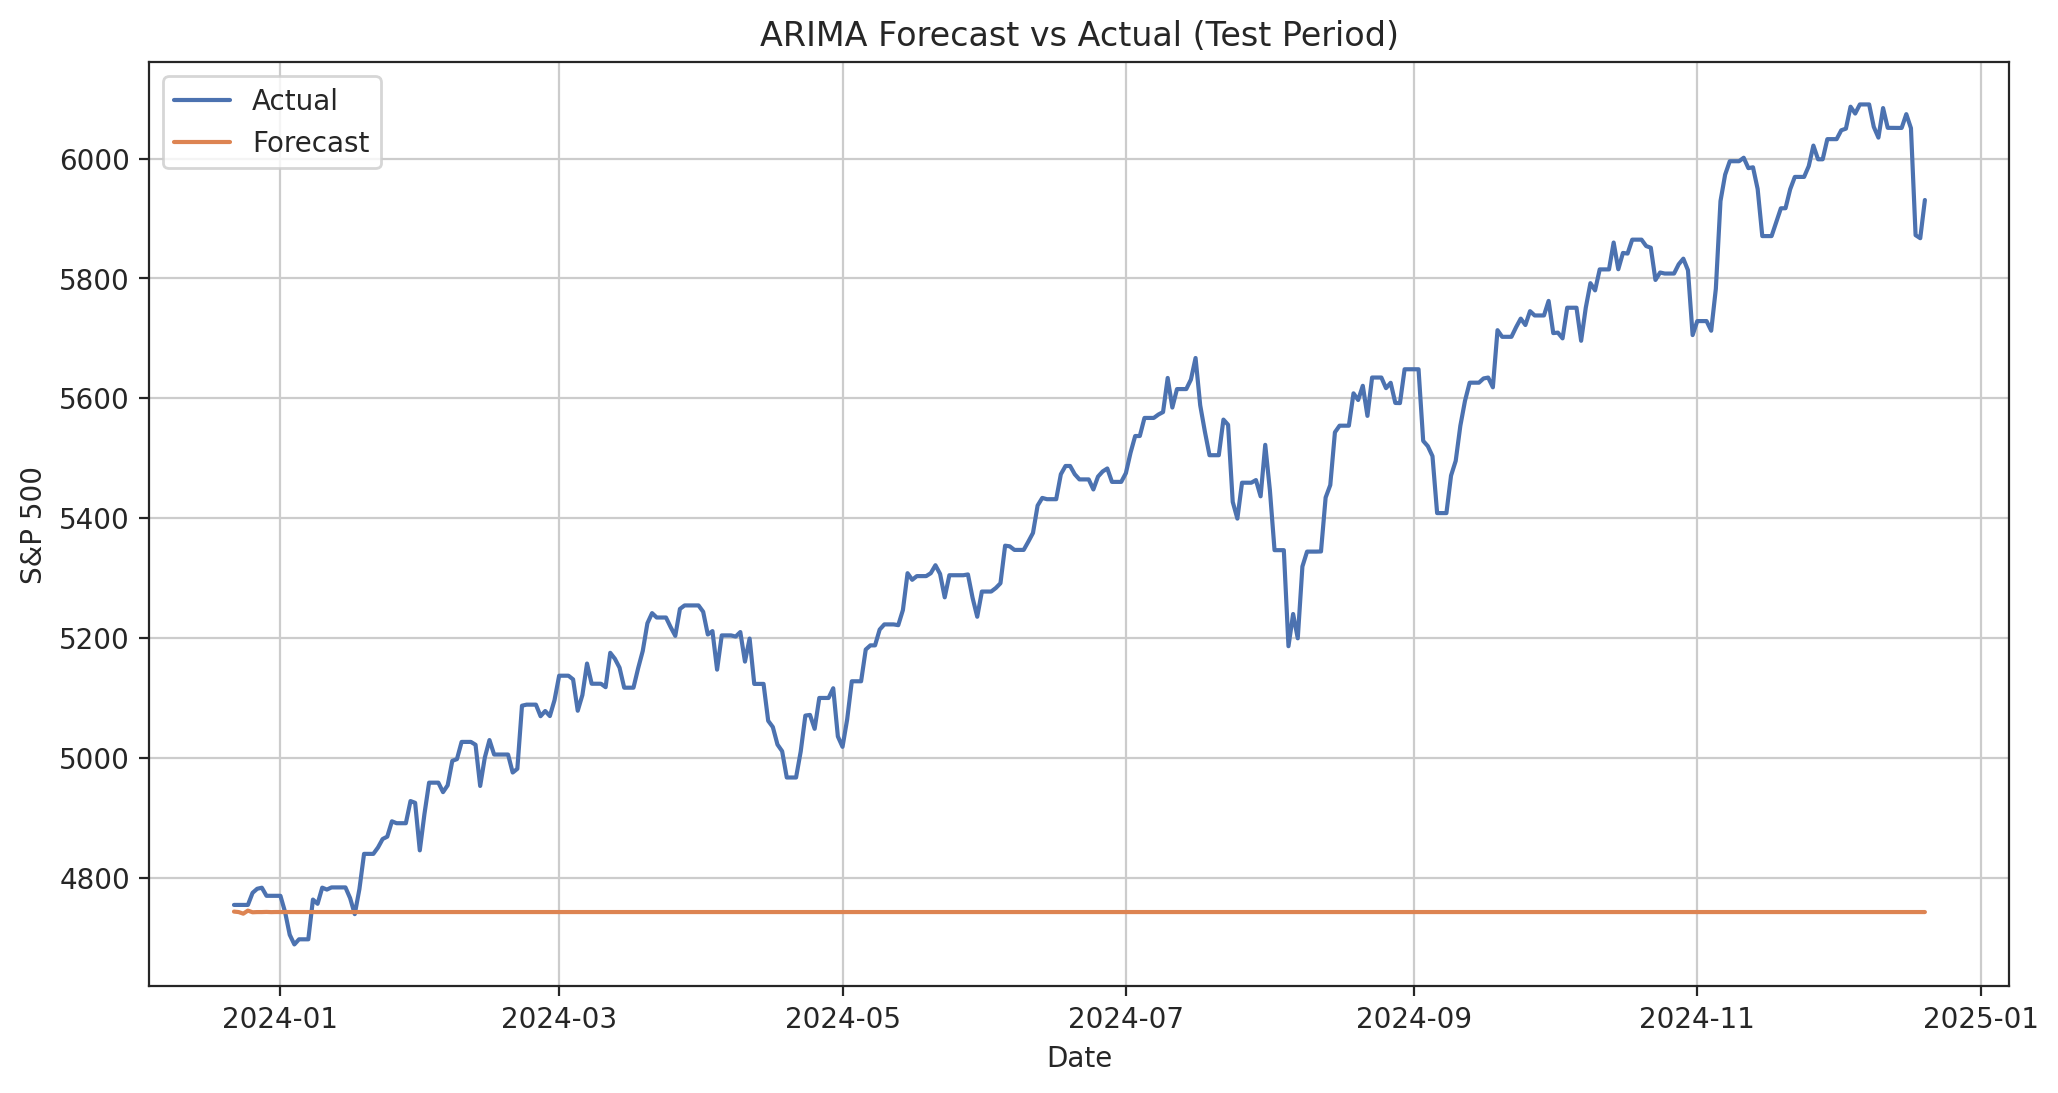

Test RMSE: 749.62


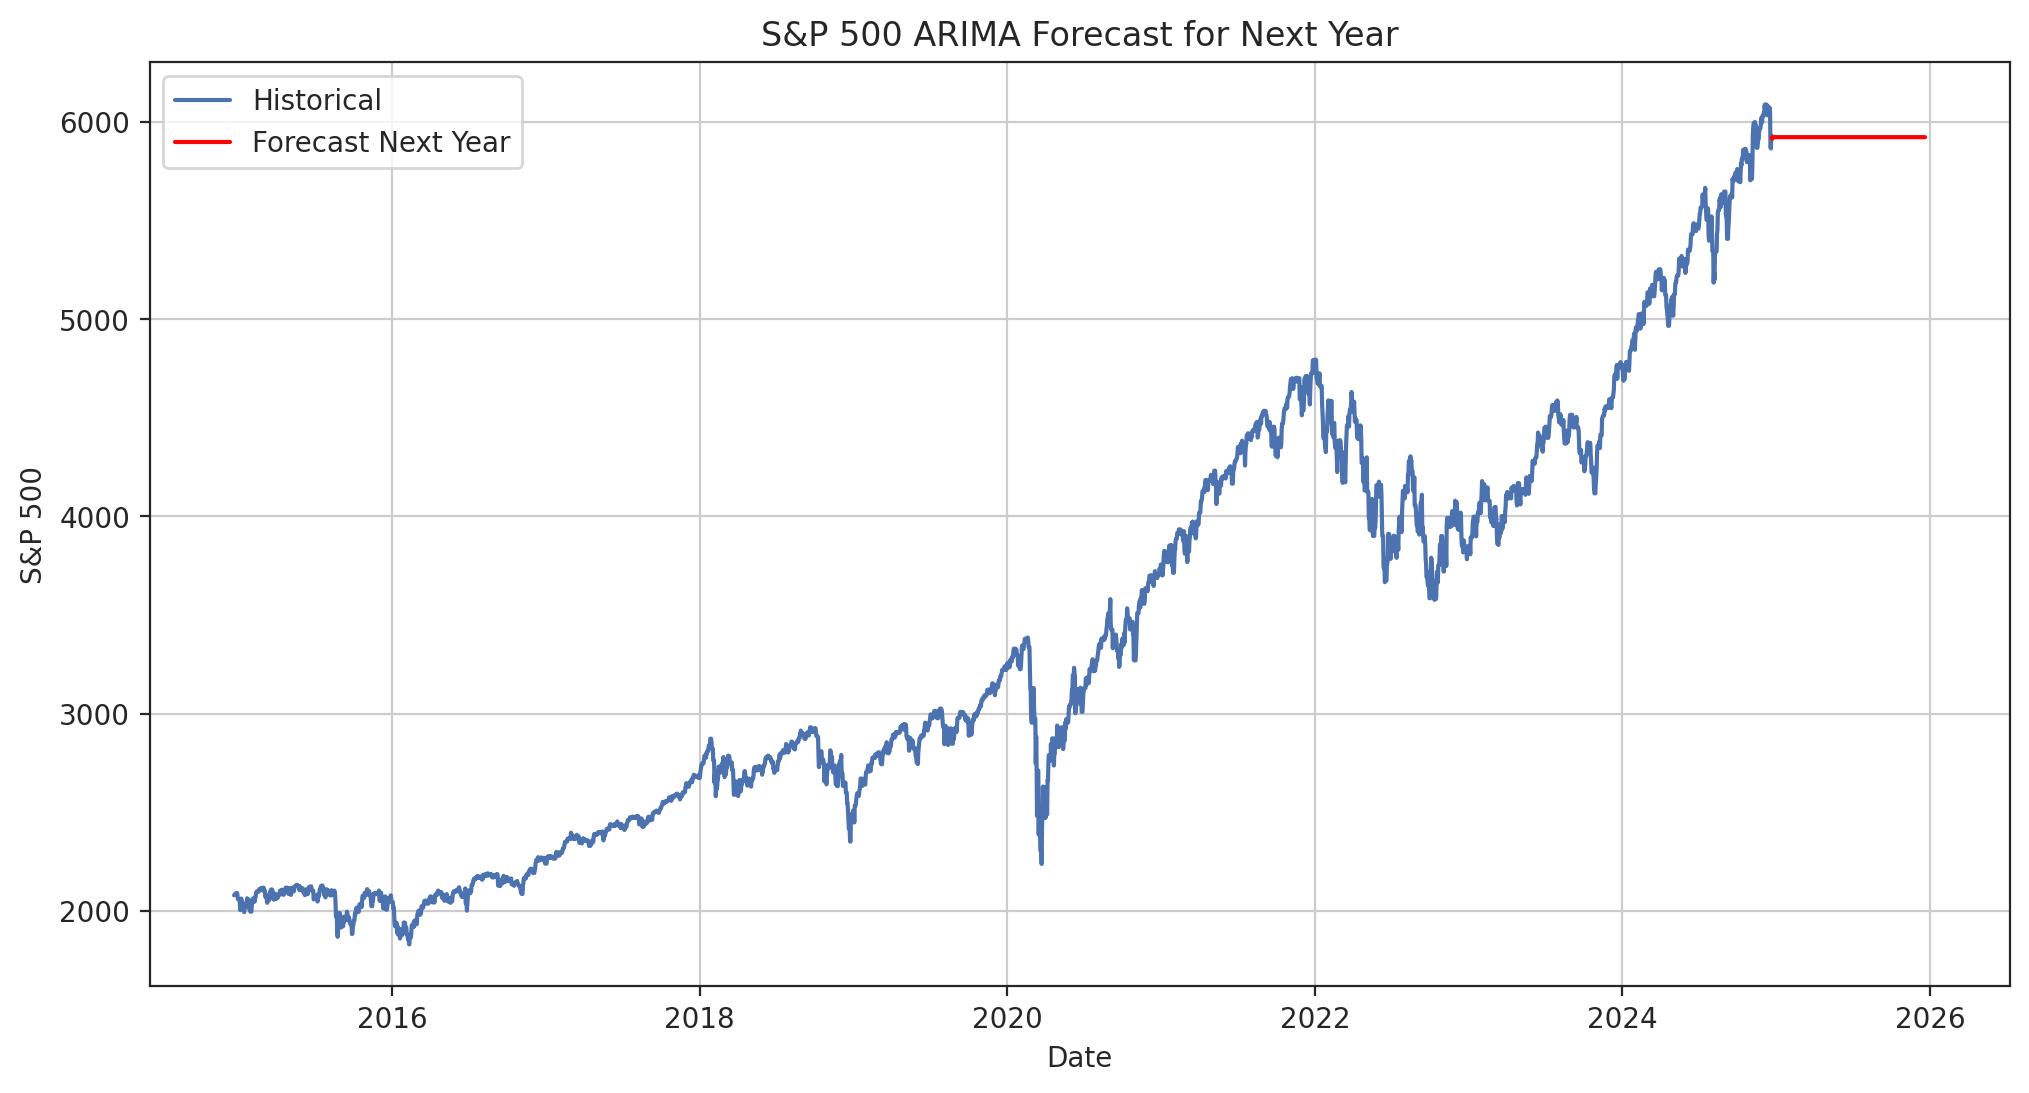

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Prepare data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample to daily frequency to fill missing dates (if any)
df = df.asfreq('D')
df['S&P500'].fillna(method='ffill', inplace=True)

# 2. Split data into train and test (last 365 days for testing)
test_size = 365
train = df['S&P500'][:-test_size]
test = df['S&P500'][-test_size:]

# 3. Fit ARIMA model
model = ARIMA(train, order=(5,1,0))  # You can tune (p,d,q)
model_fit = model.fit()

# 4. Forecast test period
forecast_test = model_fit.forecast(steps=test_size)

# 5. Plot actual vs forecast for test period
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_test, label='Forecast')
plt.title('ARIMA Forecast vs Actual (Test Period)')
plt.xlabel('Date')
plt.ylabel('S&P 500')
plt.legend()
plt.grid(True)
plt.show()

# 6. Evaluate model performance on test set
rmse = np.sqrt(mean_squared_error(test, forecast_test))
print(f"Test RMSE: {rmse:.2f}")

# 7. Refit model on full data and forecast next year
model_full = ARIMA(df['S&P500'], order=(5,1,0))
model_full_fit = model_full.fit()

forecast_next_year = model_full_fit.forecast(steps=365)
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=365, freq='D')

# Plot historical + forecast for next year
plt.figure(figsize=(12,6))
plt.plot(df.index, df['S&P500'], label='Historical')
plt.plot(future_dates, forecast_next_year, label='Forecast Next Year', color='red')
plt.title('S&P 500 ARIMA Forecast for Next Year')
plt.xlabel('Date')
plt.ylabel('S&P 500')
plt.legend()
plt.grid(True)
plt.show()
